<a href="https://colab.research.google.com/github/tirenton/Algorithmic-trading/blob/main/Project_1%2C2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance pandas numpy scipy matplotlib PyPortfolioOpt

#1. Fetching Data มา 5 ตัว

In [ ]:
import yfinance as yf
import pandas as pd
from datetime import datetime
import numpy as np

tickers = ["AAPL", "AMZN", "NFLX", "GOOGL", "TSLA"]

initial_train_start = '2018-11-01'
initial_train_end = '2023-11-01'
test_start = '2023-11-01'
test_end = '2024-11-01'

# Fetch historical adjusted close prices for the training period (5 years)
data_5y = yf.download(tickers, start=initial_train_start, end=initial_train_end)['Adj Close']
returns_5y = data_5y.pct_change().dropna()

# Fetch historical adjusted close prices for the testing period (1 year)
data_1y = yf.download(tickers, start=test_start, end=test_end)['Adj Close']
daily_returns_1y = data_1y.pct_change().dropna()


[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  5 of 5 completed


#2.a Mean-Variance Optimization

In [ ]:
from pypfopt import EfficientFrontier, risk_models, expected_returns

mu = expected_returns.mean_historical_return(data_5y)
covariance = risk_models.sample_cov(data_5y)
# print(covariance)
# cov_matrix = returns_5y.cov()
# print(cov_matrix)

ef = EfficientFrontier(mu, covariance)
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()

expected_performance = ef.portfolio_performance()
weights_list = [cleaned_weights[ticker] for ticker in tickers]

print("Optimal Weights (Mean-Variance):", weights_list)
print(f"Expected Portfolio Return (Mean-Variance): {expected_performance[0]:.2%}")
print(f"Expected Portfolio Risk (Mean-Variance): {expected_performance[1]:.2%}")
optimal_weights_mvo = weights_list

Optimal Weights (Mean-Variance): [0.59838, 0.0, 0.0, 0.0, 0.40162]
Expected Portfolio Return (Mean-Variance): 37.67%
Expected Portfolio Risk (Mean-Variance): 39.77%


# 2.a.i Balanced Mean-Variance Optimization
risk (volatility) ต่ำสุดได้เป็น 29.4% ดังนั้น target_risk เป็น 29.5%

In [ ]:
target_risk = 0.295

# Optimize for minimum volatility at the target risk level
ef = EfficientFrontier(mu, covariance)
weights = ef.efficient_risk(target_risk)
cleaned_weights = ef.clean_weights()

# Calculate expected portfolio performance
expected_performance = ef.portfolio_performance()

# Format weights as a list
weights_list = [cleaned_weights[ticker] for ticker in tickers]

print("Balanced Optimal Weights for Target Risk:", weights_list)
print(f"Expected Portfolio Return (Risk Target): {expected_performance[0]:.2%}")
print(f"Expected Portfolio Risk (Risk Target): {expected_performance[1]:.2%}")
# optimal_weights_mvo = weights_list

Balanced Optimal Weights for Target Risk: [0.42607, 0.10168, 0.04374, 0.42744, 0.00106]
Expected Portfolio Return (Risk Target): 20.24%
Expected Portfolio Risk (Risk Target): 29.50%


#2.b Sharpe Ratio Optimization

In [ ]:
from scipy.optimize import minimize

# Calculate mean returns and covariance matrix from the past data
mean_returns = returns_5y.mean()
cov_matrix = returns_5y.cov()

risk_free_rate = 0.02

def portfolio_performance(weights, mean_returns, cov_matrix):
    portfolio_return = np.sum(mean_returns * weights)
    portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return portfolio_return, portfolio_std_dev

# Function to minimize the negative Sharpe Ratio
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    portfolio_return, portfolio_risk = portfolio_performance(weights, mean_returns, cov_matrix)
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_risk
    return -sharpe_ratio

num_assets = len(mean_returns)
initial_weights = np.array([1 / num_assets] * num_assets)
bounds = [(0.1, 1.0)] * num_assets
constraints = [
    {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}
]
# Optimize Sharpe Ratio
args = (mean_returns, cov_matrix, risk_free_rate)
result = minimize(neg_sharpe_ratio, initial_weights, args=args, method='SLSQP', bounds=bounds, constraints=constraints)

# Get optimal weights
optimal_weights_sharpe = result.x

opt_return_sharpe, opt_risk_sharpe = portfolio_performance(optimal_weights_sharpe, mean_returns, cov_matrix)
opt_sharpe_ratio = (opt_return_sharpe - risk_free_rate) / opt_risk_sharpe

print("Optimal Weights (Sharpe Ratio):", optimal_weights_sharpe)
print(f"Expected Portfolio Return (Sharpe Ratio): {opt_return_sharpe:.2%}")
print(f"Expected Portfolio Risk (Sharpe Ratio): {opt_risk_sharpe:.2%}")
print(f"Sharpe Ratio: {opt_sharpe_ratio:.2f}")

Optimal Weights (Sharpe Ratio): [0.1 0.1 0.1 0.1 0.6]
Expected Portfolio Return (Sharpe Ratio): 0.19%
Expected Portfolio Risk (Sharpe Ratio): 2.93%
Sharpe Ratio: -0.62


#2.c Black-Litterman Optimization

In [ ]:
from pypfopt import BlackLittermanModel

cov_matrix = returns_5y.cov()

risk_free_rate = 0.02
expected_market_return = 0.08

# Fetch beta values for the tickers
betas = {}
for ticker in tickers:
    stock = yf.Ticker(ticker)
    betas[ticker] = stock.info['beta']

# Market-implied prior returns (using CAPM model)
market_prior = np.array([risk_free_rate + beta * (expected_market_return - risk_free_rate) for beta in betas.values()])

views = {"AAPL": 0.04, "GOOGL": 0.02, "AMZN": 0.03, "TSLA": 0.03, "NFLX": 0.03}

# Set up the Black-Litterman model
bl = BlackLittermanModel(cov_matrix=cov_matrix, pi=market_prior, absolute_views=views)
bl_adjusted_returns = bl.bl_returns()

# Optimize the portfolio with Black-Litterman adjusted returns
ef = EfficientFrontier(bl_adjusted_returns, cov_matrix)
bl_weights = ef.max_sharpe()

print("Optimal Weights (Black-Litterman):", bl_weights)

def portfolio_performance(weights, mean_returns, cov_matrix):
    weights_array = np.array(list(weights.values()))
    portfolio_return = np.sum(mean_returns * weights_array)
    portfolio_std_dev = np.sqrt(np.dot(weights_array.T, np.dot(cov_matrix, weights_array)))
    return portfolio_return, portfolio_std_dev

opt_return_bl, opt_risk_bl = portfolio_performance(bl_weights, market_prior, cov_matrix)
print(f"Expected Portfolio Return (Black-Litterman): {opt_return_bl:.2%}")
print(f"Expected Portfolio Risk (Black-Litterman): {opt_risk_bl:.2%}")

Optimal Weights (Black-Litterman): OrderedDict([('AAPL', 0.3629391436948078), ('AMZN', 0.0), ('GOOGL', 0.393704286816254), ('NFLX', 0.0), ('TSLA', 0.2433565694889383)])
Expected Portfolio Return (Black-Litterman): 11.03%
Expected Portfolio Risk (Black-Litterman): 2.10%


# 2. Buy-and-hold and Performance Analysis



Mean-Variance Optimization Metrics:
  Final Portfolio Value: $131,219.44
  Profit: $31,219.44
  Percentage Increase: 31.22%
  Sharpe Ratio: 0.89
  Rolling Volatility: 0.40
  Maximum Drawdown: -0.28
  Value at Risk (VaR 95%): -0.03
  Conditional Value at Risk (CVaR 95%): -0.04

Sharpe Ratio Optimization Metrics:
  Final Portfolio Value: $135,555.20
  Profit: $35,555.20
  Percentage Increase: 35.56%
  Sharpe Ratio: 0.86
  Rolling Volatility: 0.56
  Maximum Drawdown: -0.28
  Value at Risk (VaR 95%): -0.03
  Conditional Value at Risk (CVaR 95%): -0.05

Black-Litterman Optimization Metrics:
  Final Portfolio Value: $134,728.98
  Profit: $34,728.98
  Percentage Increase: 34.73%
  Sharpe Ratio: 1.22
  Rolling Volatility: 0.27
  Maximum Drawdown: -0.17
  Value at Risk (VaR 95%): -0.02
  Conditional Value at Risk (CVaR 95%): -0.03


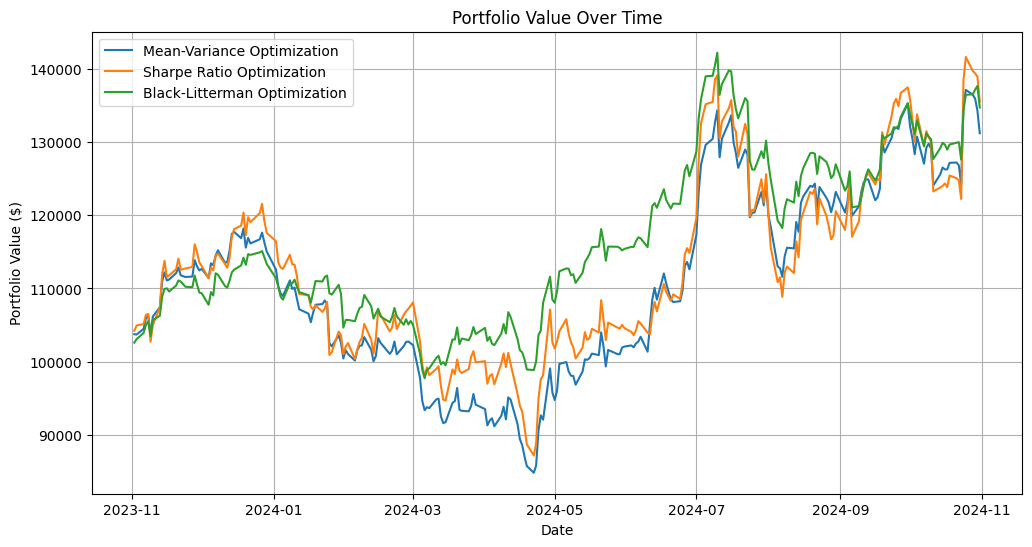

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Set initial portfolio value
initial_value = 100000  # Example initial investment amount

# Function to calculate the portfolio value based on weights and returns
def calculate_portfolio_value(initial_value, weights, returns):
    # Calculate the daily portfolio returns based on weights and individual stock returns
    daily_portfolio_returns = (returns.dot(weights)).add(1).cumprod()
    # Calculate the portfolio value over time
    portfolio_value = initial_value * daily_portfolio_returns
    return portfolio_value

# Calculate portfolio values for each strategy
portfolio_value_mvo = calculate_portfolio_value(initial_value, optimal_weights_mvo, daily_returns_1y)
portfolio_value_sharpe = calculate_portfolio_value(initial_value, optimal_weights_sharpe, daily_returns_1y)
portfolio_value_bl = calculate_portfolio_value(initial_value, np.array(list(bl_weights.values())), daily_returns_1y)

# Helper functions to calculate performance metrics
def calculate_metrics(daily_returns, risk_free_rate=0.01):
    # Sharpe Ratio
    excess_return = daily_returns.mean() - risk_free_rate / 252
    portfolio_std = daily_returns.std()
    sharpe_ratio = (excess_return / portfolio_std) * np.sqrt(252)

    # Rolling volatility (annualized)
    rolling_volatility = daily_returns.rolling(window=21).std() * np.sqrt(252)  # 21-day rolling

    # Maximum Drawdown
    cumulative_returns = (1 + daily_returns).cumprod()
    peak = cumulative_returns.cummax()
    drawdown = (cumulative_returns - peak) / peak
    max_drawdown = drawdown.min()

    # Value at Risk (VaR) at 95% confidence
    var_95 = np.percentile(daily_returns, 5)

    # Conditional Value at Risk (CVaR) at 95% confidence
    cvar_95 = daily_returns[daily_returns <= var_95].mean()

    return {
        "Sharpe Ratio": sharpe_ratio,
        "Rolling Volatility": rolling_volatility,
        "Maximum Drawdown": max_drawdown,
        "Value at Risk (VaR 95%)": var_95,
        "Conditional Value at Risk (CVaR 95%)": cvar_95
    }

# Function to display portfolio results
def display_results(strategy_name, portfolio_value, metrics):
    print(f"\n{strategy_name} Metrics:")
    final_value = portfolio_value.iloc[-1].item()  # Extract the last value as a scalar
    profit = final_value - initial_value
    percent_increase = (profit / initial_value) * 100

    print(f"  Final Portfolio Value: ${final_value:,.2f}")
    print(f"  Profit: ${profit:,.2f}")
    print(f"  Percentage Increase: {percent_increase:.2f}%")

    for metric, value in metrics.items():
        if isinstance(value, pd.Series):
            print(f"  {metric}: {value.iloc[-1].item():.2f}")  # Extract last value for rolling metrics
        else:
            print(f"  {metric}: {value:.2f}")

# Function to plot portfolio values
def plot_portfolio_values(portfolio_values, strategy_names):
    plt.figure(figsize=(12, 6))
    for portfolio_value, strategy_name in zip(portfolio_values, strategy_names):
        plt.plot(portfolio_value.index, portfolio_value, label=strategy_name)
    plt.title('Portfolio Value Over Time')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value ($)')
    plt.legend()
    plt.grid()
    plt.show()

# Calculate metrics for each portfolio
metrics_mvo = calculate_metrics(portfolio_value_mvo.pct_change().dropna())
metrics_sharpe = calculate_metrics(portfolio_value_sharpe.pct_change().dropna())
metrics_bl = calculate_metrics(portfolio_value_bl.pct_change().dropna())

# Display results for each strategy
display_results("Mean-Variance Optimization", portfolio_value_mvo, metrics_mvo)
display_results("Sharpe Ratio Optimization", portfolio_value_sharpe, metrics_sharpe)
display_results("Black-Litterman Optimization", portfolio_value_bl, metrics_bl)

# Plot portfolio values for each strategy
plot_portfolio_values(
    [portfolio_value_mvo, portfolio_value_sharpe, portfolio_value_bl],
    ["Mean-Variance Optimization", "Sharpe Ratio Optimization", "Black-Litterman Optimization"]
)
